# Dev7 Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import linearmodels
import shap
import collections
import os 

from linearmodels import PanelOLS 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.metrics import mean_squared_error

from warnings import filterwarnings
filterwarnings("ignore")

plt.style.use("ggplot")
plt.rcParams["axes.titleweight"] = "bold"
random_state = 42

data_path = "../data/"

In [2]:
def load_data(filenames, path=data_path):
    return [pd.read_csv(os.path.join(path, filename), index_col=["Country", "Year"])
            for filename in filenames]
    
X_filenames = ["dev7_X_train.csv", "dev7_X_val.csv", "dev7_X_test.csv"]
y_filenames = ["dev7_y_train.csv", "dev7_y_val.csv", "dev7_y_test.csv"]

(X_train, X_val,
 X_test) = load_data(X_filenames)
(y_train, y_val,
 y_test) = load_data(y_filenames)

## Statistical Approach

The fixed effects (FE) model represents the correlational effects of any given time-variant variables in panel data where an individual sample is observed over a several periods of time. FE is beneficial in that it recognizes that each specific sample and time period may have several unique circumstances that may affect any statistical analysis [(Salkind, 2010)](https://dx.doi.org/10.4135/9781412961288). For instance, one country's form of government or its culture may affect the volume of its GHG emissions. Additionally, each year may be associated with a specific event, say a financial crisis, that may skew the analysis by providing a downward bias for GHG emissions. While it can be argued that these factors can be inputted in a model, these factors may be unquantifiable or too numerous for researchers  to consider. FE controls for these "unobserved heterogeneities" by assuming that the aforementioned variables remain constant over time. Hence, fixed effects is appropriate in analyzing data because it helps avoid omitted variable biases.


The estimation of the Fixed Effects Linear Regression is pooled from the *vanila* Linear Regression but also considers the estimations of time-invariant variables (in this case, it is the years of GHG emissions indicated in the project). In effect, coefficients of selected features are interpreted similarly to how linear regression models are interpreted.


As part of this project, we want to compare the results from a statistical standpoint to a machine learning perspective. As such, the estimations of the linear regression with fixed effects are summarized below.

In [3]:
# retain only statistically significant features
to_drop = ["gdp_percapita", "fossilfuels_percapita", "nuclear_percapita", 
           "yearly_oil_co2", "yearly_gas_co2"]
X_train_panelreg = X_train.drop(columns=to_drop)

model = PanelOLS(y_train, X_train_panelreg, entity_effects=True)
result = model.fit(cov_type='clustered', cluster_entity=True)
result 

Dep. Variable:,ghg_mtco2,R-squared:,0.9856
Estimator:,PanelOLS,R-squared (Between):,0.2939
No. Observations:,147,R-squared (Within):,0.9856
Date:,"Mon, Feb 14 2022",R-squared (Overall):,0.3748
Time:,18:33:23,Log-likelihood,-885.14
Cov. Estimator:,Clustered,,
,,F-statistic:,1526.1
Entities:,7,P-value,0.0000
Avg Obs:,21.000,Distribution:,"F(6,134)"
Min Obs:,21.000,,
Max Obs:,21.000,F-statistic (robust):,5.84e+06


The estimates of the linear regression with fixed effects revealed that the filtered features are statistically significant at a 95% confidence level. Note that **this does not apply** for the features that were dropped such as the renewables per capita, yearly flaring, and yearly cement production. From the summary, it also revealed that the R-Squared or the explanatory power of the fixed effects model generated a result of 95.56%. This means that the model presents that GHG emissions are explainable through the variations of the independent variables.

We see some interesting results.

Firstly, a unit increase in GHG Per Capita leads to an 88.029 unit increase in GHG emissions. This means that decreasing the CO2 intensity of economic activities of these developing countries can help decrease their contribution on the climate.

Secondly, we see that coal production and flaring are significant contributors to the GHG emissions of these countries. Particularly, a unit increase in coal production increases GHG emissions by 944.43 units, meanwhile each unit of flaring increases GHG emissions by 102.82 units. This is to be expected, as these countries often engage in carbon-intensive extractive industries, particularly in coal extraction and processing oil. Any negotiation involving these countries will need to consider the environmental impact of these industries, and reducing their economic reliance on these sectors.

Thirdly, we see that cement production is a significant contributor to GHG emissions among these countries.  A unit increase results to 689.51 increase in GHG emissions. Cement is important to these countries, given that it is a material used in many construction projects. To dent their impact on the environment, developing countries will have to consider the use of more sustainable building materials. 

The last and most surprising result is the contribution of renewables on the Dev7. Particularly, 1 unit increasein renewables per capita results in a 186.11 increase in GHG emissions. This is surprising because renewables are often associated with emissions reductions. However, one should note that electricity production can still power carbon-intensive activities, for instance the operations of factories that emit GHG emissions. As such, this result may arise because renewables in developing countries power carbon intensive activities. Nonetheless, renewables are still a better alternative to coal, as coal as a power source is more carbon intensive relative to renewables. 

In [4]:
def eval(result, 
         X_val=X_val, y_val=y_val,
         X_test=X_test, y_test=y_test):
    h_val = result.predict(X_val)
    h_test = result.predict(X_test)
    
    rmse_val = np.sqrt(mean_squared_error(y_val, h_val))
    rmse_test = np.sqrt(mean_squared_error(y_test, h_test))
    
    return rmse_val, rmse_test

panelreg_val_score, panelreg_test_score = eval(result, 
                                               X_val=X_val.drop(columns=to_drop), 
                                               X_test=X_test.drop(columns=to_drop))

## Machine Learning Approaches

From [this article](https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c) we use the train set to fit the model, validation set to tune the hyperparameters, and use the test set to evaluate which model has the best performance.

### Models and Hyperparameter Space

In [5]:
#define models 
models = {
    "Linear Regression": LinearRegression(), 
    "Elastic Net": ElasticNet(random_state=random_state), 
    "kNN": KNeighborsRegressor(), 
    "SVM": SVR(kernel="linear"), 
    "Random Forest": RandomForestRegressor(random_state=random_state), 
    "Gradient Boosting": GradientBoostingRegressor(random_state=random_state), 
    "MLP": MLPRegressor(solver="lbfgs", 
                        random_state=random_state)
}

# define params
params = {
    "Linear Regression" : {}, 
    "Elastic Net": {"alpha": np.arange(1.0, 11.0, 1), 
                    "l1_ratio": np.arange(0.0, 1.1, 0.1)}, 
    "kNN": {"n_neighbors": np.arange(1, 21), 
            "weights": ["uniform", "distance"], 
            "leaf_size": np.arange(10, 55, 5),
            "p": [1, 2]}, 
    "SVM": {"gamma": ["scale", "auto"], 
            "C": [0.001, 0.01, 1, 10, 100], 
            "epsilon": np.arange(0.1, 1.1, 0.1)}, 
    "Random Forest": {"n_estimators": np.arange(100, 600, 100)}, 
    "Gradient Boosting": {"n_estimators": np.arange(100, 600, 100), 
                          "learning_rate": [0.001, 0.01, 0.1]}, 
    "MLP": {"hidden_layer_sizes": [(32,32,32), (32,16,32), (32,32,16), (16,32,32)], 
            "activation": ["logistic", "tanh", "relu"], 
            "learning_rate_init": [0.001, 0.01, 0.1]}
    }

### Model Training

In [6]:
def optim_model(model_key, feature_selection_method=None,
                X_train=X_train, y_train=y_train,
                X_val=X_val, y_val=y_val,
                X_test=X_test, y_test=y_test):
    print(f"Optimizing: {model_key}")
    
    # select features on train set
    if feature_selection_method is "RFECV":
        rfecv = RFECV(models[model_key], step=1, 
                      scoring="neg_root_mean_squared_error", 
                      cv=5, verbose=0, n_jobs=-1)
        rfecv.fit(X_train, y_train)

        n_features= rfecv.n_features_ 
        feature_names = rfecv.get_feature_names_out()
        
    elif feature_selection_method is "SFS":
        optimal_score = np.inf
        # remove guesswork by automating SFS process
        for n in np.arange(0.1, 1.1, 0.1):
            sfs = SequentialFeatureSelector(models[model_key],
                                            n_features_to_select=n,  
                                            direction="forward", 
                                            scoring="neg_root_mean_squared_error", 
                                            cv=5, 
                                            n_jobs=-1)
            sfs.fit(X_train, y_train)
            temp_model = models[model_key].fit(X_train[sfs.get_feature_names_out()], y_train)
            h = temp_model.predict(X_train[sfs.get_feature_names_out()])
            temp_score = np.sqrt(mean_squared_error(y_train, h))
            if temp_score < optimal_score:
                optimal_score = temp_score 
                n_features = sfs.n_features_to_select_
                feature_names = sfs.get_feature_names_out()
                
    elif feature_selection_method is None: 
        n_features=len(X_val.columns)
        feature_names = X_val.columns 

    # gridsearch selected features
    # tune hyperparameters on validation set
    cv_rfe = GridSearchCV(models[model_key], 
                          param_grid=params[model_key], 
                          cv=5, 
                          scoring="neg_root_mean_squared_error", 
                          verbose=0,
                          n_jobs=-1)
    X_rfe = X_val[feature_names]
    cv_rfe.fit(X_rfe, y_val)
    top_model = cv_rfe.best_estimator_
        
        
    print(f"The optimal number of features are {n_features}")
    print(f"These features are: {feature_names}")
    print("\n")
    
    # return est RMSE scores:
    h_test = top_model.predict(X_test[feature_names])
    
    test_score = np.sqrt(mean_squared_error(y_test, h_test))
    
    results_dict = {"Model": top_model, 
                    "Feature Names": feature_names, 
                    "Test Score": test_score}  
      
    return results_dict


In [7]:
# automate training process
def train(model_keys, to_opt_params):
    # init containers
    results = collections.defaultdict()
    optimal_score = np.inf
    
    # train
    for model, params in zip(model_keys, to_opt_params):
        temp_result = optim_model(model, params)
        results.setdefault(model, []).append(temp_result["Test Score"])
        if temp_result["Test Score"] < optimal_score:
            optimal_score = temp_result["Test Score"]
            optimal_feature_names = temp_result["Feature Names"]
            optimal_model = temp_result["Model"]
    # append panel regression test score
    results.setdefault("Fixed Effects", []).append(panelreg_test_score)
    
    # sort results by test score
    sorted_results = {model_name: score_val for model_name, score_val in 
                      (sorted(results.items(), key=lambda item:item[1]))}
    
    return optimal_model, optimal_feature_names, sorted_results

### Results

For model training, we do not use the recursive feature selection for `kNN` and `MLP` since they lack the attributes for `RFECV` to apply. We use `Sequential Feature Selection` for them instead.

In [8]:
# takes ~ 2 mins
top_model, top_feature_names, results = train(list(models.keys()), 
                                              ["RFECV", "RFECV", "SFS", "RFECV", 
                                               "RFECV", "RFECV", "SFS"])

Optimizing: Linear Regression
The optimal number of features are 5
These features are: ['gdp_percapita' 'fossilfuels_percapita' 'renewables_percapita'
 'yearly_coal_co2' 'yearly_cement_co2']


Optimizing: Elastic Net
The optimal number of features are 7
These features are: ['ghg_pergdp' 'gdp_percapita' 'population' 'renewables_percapita'
 'yearly_oil_co2' 'yearly_coal_co2' 'yearly_cement_co2']


Optimizing: kNN
The optimal number of features are 6
These features are: ['yearly_flaring_co2' 'gdp_percapita' 'population' 'fossilfuels_percapita'
 'yearly_coal_co2' 'yearly_cement_co2']


Optimizing: SVM
The optimal number of features are 10
These features are: ['yearly_flaring_co2' 'ghg_pergdp' 'gdp_percapita' 'population'
 'fossilfuels_percapita' 'nuclear_percapita' 'renewables_percapita'
 'yearly_oil_co2' 'yearly_coal_co2' 'yearly_cement_co2']


Optimizing: Random Forest
The optimal number of features are 6
These features are: ['ghg_pergdp' 'gdp_percapita' 'fossilfuels_percapita' 'yearly_o

In [9]:
results

{'SVM': [201.80205901179363],
 'kNN': [218.73520818560493],
 'Random Forest': [274.4996234619326],
 'MLP': [274.50464627741434],
 'Linear Regression': [286.25060534961074],
 'Elastic Net': [329.2236505014282],
 'Gradient Boosting': [568.8289421902879],
 'Fixed Effects': [1793.023859181401]}

## Model Explainability

We use a summary plot for the highest performing machine learning model. 

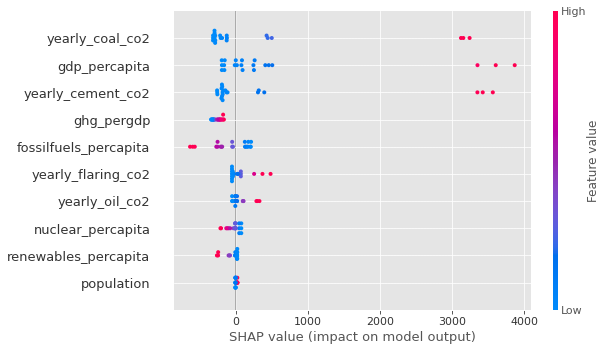

In [10]:
shap.initjs()
explainer = shap.Explainer(top_model.predict, X_train[top_feature_names])
shap_values = explainer(X_test[top_feature_names])

shap.plots.beeswarm(shap_values)

Firstly, we see that coal production is the most important feature, with higher  levels of GHG emissions being associated with higher levels of coal production.

Secondly, we observe that higher levels of  GDP per capita tend to be associated with higher levels of GHG emissions. This is to be expected, since higher levels of income and economic activity tend to be associated higher levels of GHG emissions.

Thirdly, we see that cement production is also associated with higher GHG emissions.

Fourthly, carbon intensity of economic activity (GHG per GDP) appears to be inconclusive, as high and low levels of carbon intensity are associated with lower GHG emissions.

Fifth, higher levels of electricity production by fossil fuels (indicated by fossil fuels per capita) is associated with lower GHG emissions. Potentially, this may occur because some fossil fuels are less carbon intensive than others. For instance, natural gas is less carbon intensive than coal and oil. If these results are to be believed, the Dev7 at the higher end of the spectrum  may potentially be using more efficient fossi fuels.

Sixth, we see that higher levels of activities related to the extraction and processing of oil products, name;y  flaring and oil production are associated with higher levels of GHG e




### Feature Importance

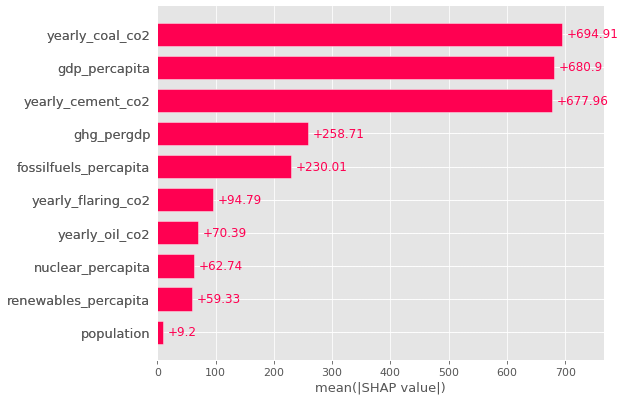

In [11]:
shap.plots.bar(shap_values.abs.mean(0))

### Explanation for a single sample

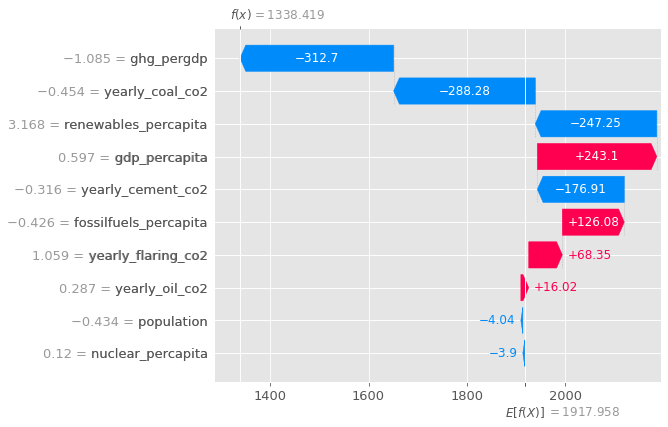

In [12]:
# Generate random index
rng = np.random.default_rng(random_state)
random_idx = rng.integers(low=0, high=X_test.shape[0])

shap.plots.waterfall(shap.Explanation(
    base_values=shap_values[0][0].base_values, 
    values = shap_values[0].values, 
    feature_names = top_feature_names, 
    data = X_test[top_feature_names].iloc[random_idx]
))

In [13]:
%load_ext watermark
%watermark -v -iv 

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

pandas      : 1.3.4
shap        : 0.40.0
linearmodels: 4.24
sys         : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:15:42) [MSC v.1916 64 bit (AMD64)]
sklearn     : 1.0
matplotlib  : 3.4.3
numpy       : 1.20.3

